<a href="https://colab.research.google.com/github/dwarfy35/deep_learning2/blob/main/ColabNoteBook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [167]:
import matplotlib.pyplot as plt

In [168]:
class MinibatchDiscrimination(nn.Module):
    def __init__(self, in_features, out_features, intermediate_features):
        super().__init__()
        self.T = nn.Parameter(torch.randn(in_features, intermediate_features))
    def forward(self, x):
        M = x.mm(self.T)
        M = M.unsqueeze(0) - M.unsqueeze(1)
        M = torch.exp(-torch.abs(M).sum(dim=2))
        return torch.cat([x, M.mean(dim=0)], dim=1)


In [169]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from google.colab import drive

drive.mount('/content/gdrive')

nz = 126
# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

nc = 1

ngpu = 1

# Hyperparameters and configurations
num_classes = 26
num_epochs = 100  # Set the number of training epochs
M = 32  # Batch size
N_disc = 1 # Number of discriminator iterations per generator iteration
lambda_coeff = 10  # Coefficient λ for the gradient penalty
alpha, beta1, beta2 = 0.0002, 0.5 , 0.999  # Adam hyperparameters

# Initialize model parameters
w = torch.randn((1,), requires_grad=True)  # Discriminator parameters
theta = torch.randn((1,), requires_grad=True)  # Generator parameters

# Optimizers



def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Placeholder functions for model components
def sample_real_data(class_label):
    return torch.randn(32, 32)  # Dummy 32x32 image

def sample_style_vector(batch_size = 1):
    return torch.FloatTensor(batch_size, 100).uniform_(-1, 1)

class NPZDataset(Dataset):
    def __init__(self, npz_file, transform=None, filter_label=None, num_samples=None):
        # Load the data from the .npz file
        data = np.load(npz_file)
        self.images = data['images']
        self.labels = data['labels']
        self.transform = transform

        # Filter by label if specified
        if filter_label is not None:
            # Find indices of the desired label
            label_indices = np.where(self.labels == filter_label)[0]

            # If num_samples is specified, limit the number of samples
            if num_samples is not None:
                label_indices = label_indices[:num_samples]

            # Filter images and labels
            self.images = self.images[label_indices]
            self.labels = self.labels[label_indices]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get the image and label for the given index
        image = self.images[idx]
        label = self.labels[idx]

        # Reshape the image to add a channel dimension
        image = image[np.newaxis, ...]  # Add channel dimension at the beginning

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        # Convert to PyTorch tensor if necessary
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return image, label


# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
            #nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            #nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            #nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            #nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            #nn.BatchNorm2d(ndf * 8),
            #nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            #nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            #nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

def gradient_penalty(discriminator, real_data, fake_data):
    alpha = torch.rand(real_data.size(0), 1, 1, 1, device=real_data.device)
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates.requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients_norm = gradients.view(gradients.size(0), -1).norm(2, dim=1)
    penalty = ((gradients_norm - 1) ** 2).mean()
    #print(f"Gradient Norm: {gradients_norm.mean().item()}, Penalty: {penalty.item()}")

    return penalty

discriminator = Discriminator(ngpu)
discriminator.apply(weights_init)
generator = Generator(ngpu)
generator.apply(weights_init)
npz_file = '/content/gdrive/My Drive/character_font.npz'  # Path to your npz file
data_test = np.load(npz_file)
data_A_s = []
#for i in range(100):
  #data_A_s.append(data_test['images'][i*26])
  #print(data_test['labels'][i*26])

class TestDataset(Dataset):
    def __init__(self, data, transform=None):
        # Load the data from the .npz file
        self.images = data
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get the image and label for the given index
        image = self.images[idx]

        # Reshape the image to add a channel dimension
        # Assuming images are grayscale, add a channel dimension of 1
        image = image[np.newaxis, ...]  # Add channel dimension at the beginning

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        # Convert to PyTorch tensor if necessary
        image = torch.tensor(image, dtype=torch.float32)

        return image

transform = None  # Define any torchvision transforms you want to apply
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

#dataset = NPZDataset(npz_file, transform=transform)
dataset = NPZDataset(npz_file, transform, 0, 10000)
dataloader = DataLoader(dataset, batch_size=M, shuffle=True)

# Training loop



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [170]:
def genTestImg():
    z_c = torch.zeros(num_classes)
    z_c[c] = 1
    z_s = sample_style_vector(1)
    #x = torch.tensor(np.random.normal(0, 1, (1, 1, 32, 32)), dtype=torch.float32)
    z = torch.cat((z_s, z_c.repeat(1, 1)), dim=1)
    z = z.view(1, 126, 1, 1)
    img = generator(z)
    img = img.detach().numpy()[0, 0]  # Get the single channel for greyscale
    #img = np.uint8(np.interp(img, (-1, 1), (0, 255)))  # Scale values for display
    plt.imshow(img, cmap='gray')  # Display in greyscale
    plt.axis("off")
    plt.show()

In [171]:
import matplotlib.pyplot as plt
import numpy as np

def genTestImg(c):
    z_c = torch.zeros(1, num_classes, device=device)
    z_c[c] = 1
    z_s = sample_style_vector(1).to(device)
    z = torch.cat((z_s, z_c), dim=1).view(1, 126, 1, 1).to(device)
    img = generator(z).detach().cpu().numpy()[0, 0]
    img = np.uint8(np.interp(img, (-1, 1), (0, 255)))  # Scale to [0, 255]
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()



In [172]:
def sample_style_vector(batch_size = 1):
    return torch.FloatTensor(batch_size, 100).uniform_(-1, 1)

In [173]:
optimizer_D = optim.Adam(discriminator.parameters(), lr=alpha, betas=(beta1, beta2))
optimizer_G = optim.Adam(generator.parameters(), lr=alpha, betas=(beta1, beta2))

<ipython-input-169-5ca522be126f>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


D_real: 0.00251381890848279, D_fake: 0.0004097787896171212
Gradient Penalty: 19.734922409057617
D_real: 0.003702374640852213, D_fake: 0.00031397404382005334
Gradient Penalty: 19.73600959777832
D_real: 0.003700845642015338, D_fake: 0.0004695158277172595
Gradient Penalty: 19.73736000061035
D_real: 0.0038025116082280874, D_fake: 0.00032544368878006935
Gradient Penalty: 19.734277725219727
D_real: 0.0025866744108498096, D_fake: 0.00029810937121510506
Gradient Penalty: 19.733234405517578
D_real: 0.0029332423582673073, D_fake: 0.00031876974389888346
Gradient Penalty: 19.735252380371094
D_real: 0.0024134707637131214, D_fake: 0.0002126289182342589
Gradient Penalty: 19.735139846801758
D_real: 0.0022819354198873043, D_fake: 0.00030386721482500434
Gradient Penalty: 19.731855392456055
D_real: 0.0029876274056732655, D_fake: 0.00041075467015616596
Gradient Penalty: 19.7335147857666
D_real: 0.003369102254509926, D_fake: 0.00034698302624747157
Gradient Penalty: 19.7379150390625
D_real: 0.00318892439827

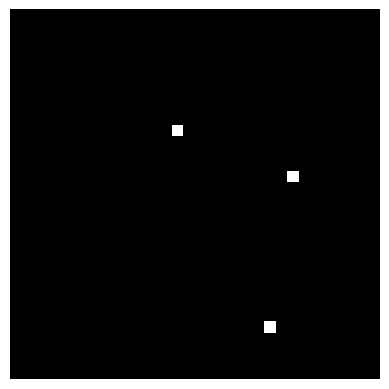

main.0.weight - Grad Norm: 0.0002571547811385244
main.2.weight - Grad Norm: 0.00025181990349665284
main.4.weight - Grad Norm: 0.0002471710613463074
main.6.weight - Grad Norm: 0.00018979428568854928
Epoch [1/100] - D Loss: 19.7332, G Loss: -0.0000
D_real: 0.007316629868000746, D_fake: 0.0004251599602866918
Gradient Penalty: 19.724523544311523
D_real: 0.006453275214880705, D_fake: 0.0003685657284222543
Gradient Penalty: 19.7248477935791
D_real: 0.006845131516456604, D_fake: 0.0004556328058242798
Gradient Penalty: 19.726245880126953
D_real: 0.00714823929592967, D_fake: 0.00038770679384469986
Gradient Penalty: 19.721683502197266
D_real: 0.006285489536821842, D_fake: 0.00055810681078583
Gradient Penalty: 19.725414276123047
D_real: 0.006592260207980871, D_fake: 0.0005213418626226485
Gradient Penalty: 19.719812393188477
D_real: 0.00664263591170311, D_fake: 0.0005943350843153894
Gradient Penalty: 19.72224235534668
D_real: 0.006536013912409544, D_fake: 0.00043003587052226067
Gradient Penalty: 1

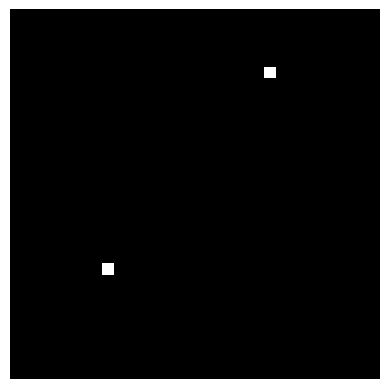

main.0.weight - Grad Norm: 0.0002668013039510697
main.2.weight - Grad Norm: 0.0002670749672688544
main.4.weight - Grad Norm: 0.0002709153341129422
main.6.weight - Grad Norm: 0.00027214817237108946
Epoch [2/100] - D Loss: 19.7154, G Loss: -0.0000
D_real: 0.010564880445599556, D_fake: 0.000520136789418757
Gradient Penalty: 19.703950881958008
D_real: 0.01097901165485382, D_fake: 0.0007446478120982647
Gradient Penalty: 19.704360961914062
D_real: 0.010330529883503914, D_fake: 0.000749406754039228
Gradient Penalty: 19.709068298339844
D_real: 0.010249335318803787, D_fake: 0.0005415311316028237
Gradient Penalty: 19.710041046142578
D_real: 0.010640495456755161, D_fake: 0.0006693274481222034
Gradient Penalty: 19.70821762084961
D_real: 0.011861768551170826, D_fake: 0.0009479719446972013
Gradient Penalty: 19.708354949951172
D_real: 0.01127631589770317, D_fake: 0.0006486561615020037
Gradient Penalty: 19.70241355895996
D_real: 0.010348329320549965, D_fake: 0.000555996666662395
Gradient Penalty: 19.7

KeyboardInterrupt: 

In [174]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move models to device
discriminator = Discriminator(ngpu)
discriminator.apply(weights_init)
generator = Generator(ngpu)
generator.apply(weights_init)

generator = generator.to(device)
discriminator = discriminator.to(device)

optimizer_D = optim.Adam(discriminator.parameters(), lr=alpha/2, betas=(beta1, beta2))
optimizer_G = optim.Adam(generator.parameters(), lr=alpha, betas=(beta1, beta2))

# Training loop
for epoch in range(num_epochs):
    for c in range(1):
        # Set one-hot vector for current class
        z_c = torch.zeros(num_classes, device=device)
        z_c[c] = 1

        # Discriminator update
        for _ in range(N_disc):
            # Initialize discriminator loss
            D_loss = 0

            for i, (image, label) in enumerate(dataloader):
                # Move real images to device
                x_real = image.to(device)
                x_real = x_real.view(x_real.size()[0], 1, 32, 32)

                # Sample style vector and move to device
                z_s = sample_style_vector(x_real.size()[0]).to(device)

                # Generate fake data
                z = torch.cat((z_s, z_c.repeat(x_real.size()[0], 1)), dim=1).to(device)
                z = z.view(x_real.size()[0], 126, 1, 1)

                x_fake = generator(z)

                # Discriminator loss calculation
                x_fake = x_fake.view(x_real.size()[0], 1, 32, 32)

                # Add noise to real and fake data
                real_with_noise = x_real + 0.1 * torch.randn_like(x_real)
                fake_with_noise = x_fake + 0.1 * torch.randn_like(x_fake)

                D_real = discriminator(real_with_noise)
                D_fake = discriminator(fake_with_noise)
                print(f"D_real: {torch.mean(D_real).item()}, D_fake: {torch.mean(D_fake).item()}")

                grad_penalty = 2 * lambda_coeff * gradient_penalty(discriminator, real_with_noise, fake_with_noise)

                print(f"Gradient Penalty: {grad_penalty.item()}")

                D_loss += -torch.mean(D_real) + torch.mean(D_fake) + grad_penalty

            D_loss /= len(dataloader)

            # Update discriminator weights
            optimizer_D.zero_grad()
            D_loss.backward()
            optimizer_D.step()

        # Generator update
        for _ in range(5):
          G_loss = 0
          z_s = sample_style_vector(1).to(device)
          for _ in range(M):
              # Sample style vector and move to device
              #z_s = sample_style_vector(1).to(device)
              z = torch.cat((z_s, z_c.repeat(1, 1)), dim=1).to(device)
              z = z.view(1, 126, 1, 1)

              # Generate fake data and calculate generator loss
              x_fake = generator(z)
              x_fake = x_fake.view(1, 1, 32, 32)
              G_loss += -torch.mean(discriminator(x_fake))

          G_loss /= M

        # Update generator weights
        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()

        # Generate test image
        genTestImg(c)
    for name, param in generator.named_parameters():
      print(f"{name} - Grad Norm: {param.grad.norm()}")

    print(f"Epoch [{epoch+1}/{num_epochs}] - D Loss: {D_loss.item():.4f}, G Loss: {G_loss.item():.4f}")
